In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import json
import os

In [2]:
PATH_METHYLATION = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/Methylation"
FILE_PATH_DICT = "case_id_and_structure.json"

In [3]:
with open(FILE_PATH_DICT, 'r') as file:
    file_parsed = json.load(file)
methylation_folder_list = []
for key in file_parsed.keys():
    methylation_folder_list.append(file_parsed[key]["files"]["methylation"])   

In [4]:
list_df_Met = []
number_of_rows = []
for root, dirs, files in os.walk(PATH_METHYLATION):
    for dir in dirs:
        for root, dirs, files in os.walk(PATH_METHYLATION + "/" + dir):
            for file in files:
                if file in methylation_folder_list:
                    list_df_Met.append(pd.read_csv(PATH_METHYLATION + "/" + dir + "/" + file, sep='\t', header= None, names= ["id", "methylation"]))
                    with open(PATH_METHYLATION + "/" + dir + "/" + file, 'r') as fp:
                        lines = len(fp.readlines())
                        number_of_rows.append(int(lines))

methylation = pd.Series(number_of_rows)


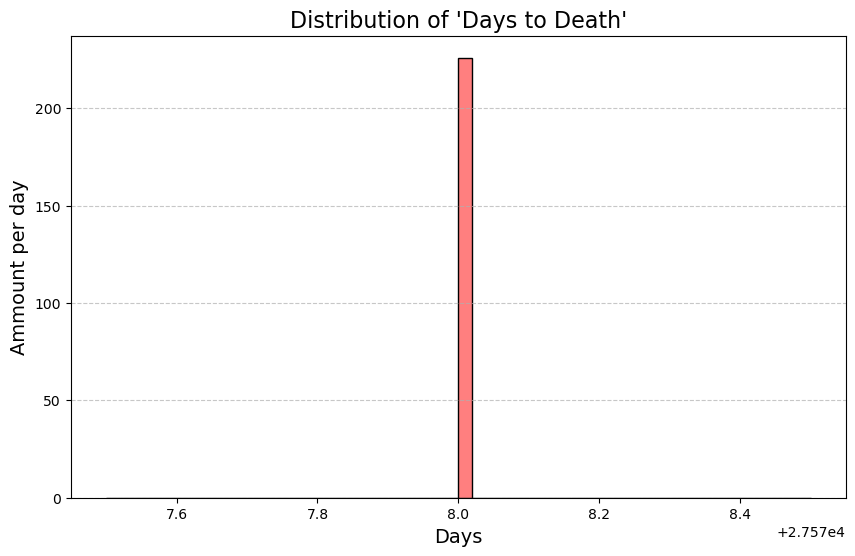

In [5]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(methylation, bins=50, kde=True, color="red")
plt.title("Distribution of \'Days to Death\'", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Ammount per day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
print(methylation.max())
print(methylation.min())

27578
27578


In [7]:
# Lista che conterrà le posizioni dei NaN per ogni file
list_of_NaN = {}
count = 0
count_record = 0
# Cammina nella directory
for root, dirs, files in os.walk(PATH_METHYLATION):
    for file in files:
        # Controlla se il file è nella lista specificata
        if file in methylation_folder_list:
            file_path = os.path.join(root, file)
            # Apri il file e leggi riga per riga
            with open(file_path, 'r') as fp:
                lines = fp.readlines()
            # Cerca "NA" in ogni riga e salva la posizione
            nan_positions = []
            for i, line in enumerate(lines):
                count_record = count_record +1
                if "NA" in line:  # Verifica se "NA" è presente nella riga
                    nan_positions.append(i)
                    count = count +1
            # Aggiungi alla lista di liste
            list_of_NaN[file] = nan_positions

# Trasforma la lista in una serie di pandas per un'analisi più semplice
methylation = pd.Series(list_of_NaN)

# Stampa i risultati
print(type(list_of_NaN))
print(methylation)
print(len(list_of_NaN))
print(count)
print(count_record)
print(count/count_record)



<class 'dict'>
c3f5ce9a-9138-4ef2-ae07-3c6985595aa9.methylation_array.sesame.level3betas.txt    [9, 22, 46, 54, 55, 58, 60, 69, 83, 88, 102, 1...
8d2a609e-c2c3-4519-ae30-c7b6330c2c71.methylation_array.sesame.level3betas.txt    [9, 22, 46, 54, 55, 58, 60, 69, 83, 88, 102, 1...
d4292db8-ecae-4127-9989-0e7e9ee9d3ec.methylation_array.sesame.level3betas.txt    [9, 22, 39, 46, 50, 54, 55, 58, 60, 69, 83, 88...
287e60d5-8f5d-4604-98ac-f771fca970fb.methylation_array.sesame.level3betas.txt    [9, 22, 46, 54, 55, 58, 60, 69, 83, 88, 102, 1...
e0b5c688-22c0-4c9a-b52d-9e9394449886.methylation_array.sesame.level3betas.txt    [9, 22, 46, 50, 54, 55, 58, 60, 69, 83, 88, 10...
                                                                                                       ...                        
49b80937-9772-45fe-89b9-c46d0eabbe94.methylation_array.sesame.level3betas.txt    [9, 22, 46, 50, 54, 55, 58, 60, 69, 83, 88, 10...
9855b9f1-6c59-4fe1-ba86-8fd94a95f63c.methylation_array.sesame.level3

In [8]:
for idx, file in enumerate(list_of_NaN):
    count_na = len(file)
    print(f"Riga {idx + 1}: {count_na} valori NA")

Riga 1: 77 valori NA
Riga 2: 77 valori NA
Riga 3: 77 valori NA
Riga 4: 77 valori NA
Riga 5: 77 valori NA
Riga 6: 77 valori NA
Riga 7: 77 valori NA
Riga 8: 77 valori NA
Riga 9: 77 valori NA
Riga 10: 77 valori NA
Riga 11: 77 valori NA
Riga 12: 77 valori NA
Riga 13: 77 valori NA
Riga 14: 77 valori NA
Riga 15: 77 valori NA
Riga 16: 77 valori NA
Riga 17: 77 valori NA
Riga 18: 77 valori NA
Riga 19: 77 valori NA
Riga 20: 77 valori NA
Riga 21: 77 valori NA
Riga 22: 77 valori NA
Riga 23: 77 valori NA
Riga 24: 77 valori NA
Riga 25: 77 valori NA
Riga 26: 77 valori NA
Riga 27: 77 valori NA
Riga 28: 77 valori NA
Riga 29: 77 valori NA
Riga 30: 77 valori NA
Riga 31: 77 valori NA
Riga 32: 77 valori NA
Riga 33: 77 valori NA
Riga 34: 77 valori NA
Riga 35: 77 valori NA
Riga 36: 77 valori NA
Riga 37: 77 valori NA
Riga 38: 77 valori NA
Riga 39: 77 valori NA
Riga 40: 77 valori NA
Riga 41: 77 valori NA
Riga 42: 77 valori NA
Riga 43: 77 valori NA
Riga 44: 77 valori NA
Riga 45: 77 valori NA
Riga 46: 77 valori 

               id  methylation
0      cg00000292     0.716561
1      cg00002426     0.050503
2      cg00003994     0.016429
3      cg00005847     0.885254
4      cg00006414     0.033973
...           ...          ...
27573  cg27657283     0.022251
27574  cg27661264     0.167516
27575  cg27662379     0.014776
27576  cg27662877     0.022849
27577  cg27665659     0.011848

[27578 rows x 2 columns]


In [ ]:
#parte che va a eliminare le righe
entire_list_of_Nan = set()
for k in list_of_NaN.keys():
    for j in range(len(list_of_NaN[k])):
        entire_list_of_Nan.add(list_of_NaN[k][j])

print(len(entire_list_of_Nan))

list_df_Met_without_na = [] #lista dataframe senza le righe Nan

for i in range(len(list_df_Met)):
    list_df_Met_without_na.append(list_df_Met[i].dropna())

print(list_df_Met_without_na[0])
#print(list_df_Met_without_na[0].head())

8239
               id  methylation
0      cg00000292     0.716561
1      cg00002426     0.050503
2      cg00003994     0.016429
3      cg00005847     0.885254
4      cg00006414     0.033973
...           ...          ...
27573  cg27657283     0.022251
27574  cg27661264     0.167516
27575  cg27662379     0.014776
27576  cg27662877     0.022849
27577  cg27665659     0.011848

[24935 rows x 2 columns]


In [ ]:
#parte che va a sostituire tutti i NaN con 0
list_df_Met_0_filled = [] #lista dataframe con righe Nan =0
for i in range(len(list_df_Met)):
    list_df_Met_0_filled.append(list_df_Met[i].fillna(0))

print(list_df_Met_0_filled[0])
#print(list_df_Met_0_filled[0].head())

# Create Graph

In [35]:
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import os

ModuleNotFoundError: No module named 'torch_geometric'

In [30]:
# Unisci tutti i DataFrame in uno solo
df_Met_without_na = pd.concat(list_df_Met_without_na, ignore_index=True)
df_Met_0_filled = pd.concat(list_df_Met_0_filled, ignore_index=True)

##without_NaN

Media della metilazione: 0.2282068279164628
Mediana della metilazione: 0.0339775544333965


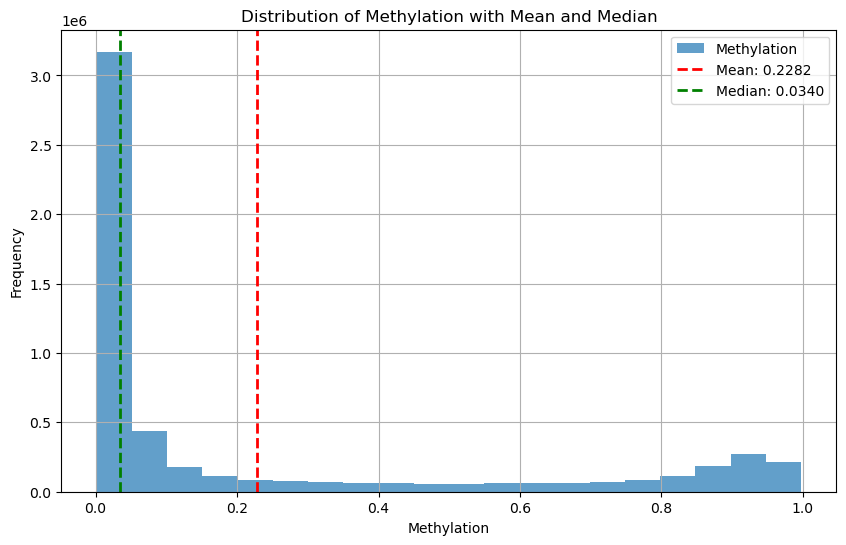

In [36]:
# Calcola la media e la mediana della colonna 'methylation' di df_Met_without_na
mean_methylation_without_na = df_Met_without_na['methylation'].mean()
median_methylation_without_na = df_Met_without_na['methylation'].median()

print("Media della metilazione:", mean_methylation_without_na)
print("Mediana della metilazione:", median_methylation_without_na)

# Rappresenta la media e la mediana in un grafico
plt.figure(figsize=(10, 6))
plt.hist(df_Met_without_na['methylation'], bins=20, alpha=0.7, label='Methylation')
plt.axvline(mean_methylation_without_na, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_methylation_without_na:.4f}')
plt.axvline(median_methylation_without_na, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_methylation_without_na:.4f}')
plt.xlabel('Methylation')
plt.ylabel('Frequency')
plt.title('Distribution of Methylation with Mean and Median')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
THRESHOLD_WITHOUT_NA = median_methylation_without_na

# I'm just gonna do it for the first 2, as an example, in the deployed one
# we obviusly need to do it for all.

list_of_Data_without_NaN = []

for case_index in range(0, 2):
    feature_size = df_Met_without_na['methylation'].shape[0]
    edges = [[],[]]

    for f_1_index in range(feature_size):
        for f_2_index in range(f_1_index + 1, df_Met_without_na.shape[0]):
            similarity = np.linalg.norm(   
                df_Met_without_na['methylation'].iloc[f_1_index] - \
                df_Met_without_na['methylation'].iloc[f_2_index])
            if similarity <= THRESHOLD_WITHOUT_NA:
                edges[0].append(f_1_index)
                edges[0].append(f_2_index)
                edges[1].append(f_2_index)
                edges[1].append(f_1_index)
    
    edge_index = torch.tensor(edges, dtype=torch.long)
    x = torch.tensor(list(df_Met_without_na['methylation']), dtype=torch.float)

    list_of_Data_without_NaN.append(Data(x=x, edge_index=edge_index))

NameError: name 'np' is not defined

In [ ]:
G1 = to_networkx(list_of_Data_without_NaN[0], to_undirected=True)

print("Numero di nodi:", G1.number_of_nodes())
print("Numero di archi:", G1.number_of_edges())

# Grado di ciascun nodo (numero di connessioni per gene)
degrees = dict(G1.degree())
print("Gradi dei nodi:", degrees)

# Nodo con il massimo grado (gene con più connessioni)
max_degree_node = max(degrees, key=degrees.get)
print(f"Gene con il massimo grado: {max_degree_node} ({degrees[max_degree_node]} connessioni)")

# Trova tutte le componenti connesse
connected_components = list(nx.connected_components(G1))
print("Numero di componenti connesse:", len(connected_components))

##0_filled

In [ ]:
# Calcola la media e la mediana della colonna 'methylation' di df_Met_0_filled
mean_methylation_0_filled = df_Met_0_filled['methylation'].mean()
median_methylation_0_filled = df_Met_0_filled['methylation'].median()

print("Media della metilazione:", mean_methylation_0_filled)
print("Mediana della metilazione:", median_methylation_0_filled)

# Rappresenta la media e la mediana in un grafico
plt.figure(figsize=(10, 6))
plt.hist(df_Met_0_filled['methylation'], bins=20, alpha=0.7, label='Methylation')
plt.axvline(mean_methylation_0_filled, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_methylation_0_filled:.4f}')
plt.axvline(median_methylation_0_filled, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_methylation_0_filled:.4f}')
plt.xlabel('Methylation')
plt.ylabel('Frequency')
plt.title('Distribution of Methylation with Mean and Median')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
THRESHOLD_0_FILLED = median_methylation_0_filled

# I'm just gonna do it for the first 2, as an example, in the deployed one
# we obviusly need to do it for all.

list_of_Data_0_filled = []

for case_index in range(0, 2):
    feature_size = df_Met_0_filled['methylation'].shape[0]
    edges = [[],[]]

    for f_1_index in range(feature_size):
        for f_2_index in range(f_1_index + 1, df_Met_0_filled.shape[0]):
            similarity = np.linalg.norm(   
                df_Met_0_filled['methylation'].iloc[f_1_index] - \
                df_Met_0_filled['methylation'].iloc[f_2_index])
            if similarity <= THRESHOLD_0_FILLED:
                edges[0].append(f_1_index)
                edges[0].append(f_2_index)
                edges[1].append(f_2_index)
                edges[1].append(f_1_index)
    
    edge_index = torch.tensor(edges, dtype=torch.long)
    x = torch.tensor(list(df_Met_0_filled['methylation']), dtype=torch.float)

    list_of_Data_0_filled.append(Data(x=x, edge_index=edge_index))

In [ ]:
G2 = to_networkx(list_of_Data_0_filled[0], to_undirected=True)

print("Numero di nodi:", G2.number_of_nodes())
print("Numero di archi:", G2.number_of_edges())

# Grado di ciascun nodo (numero di connessioni per gene)
degrees = dict(G2.degree())
print("Gradi dei nodi:", degrees)

# Nodo con il massimo grado (gene con più connessioni)
max_degree_node = max(degrees, key=degrees.get)
print(f"Gene con il massimo grado: {max_degree_node} ({degrees[max_degree_node]} connessioni)")

# Trova tutte le componenti connesse
connected_components = list(nx.connected_components(G2))
print("Numero di componenti connesse:", len(connected_components))